#### Set the working directory to ../systematic-clusters-analysis_shahein-et.al

In [5]:
cd '../'

In [20]:
os.getcwd()

'/Users/transcend/SynologyDrive/python_analysis/systematic-clusters-analysis_shahein-et.al'

## Setup

In [2]:
import xlrd
import json
import os
import pickle
import emcee
import corner

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lmfit as lm
from lmfit import Model, fit_report

from more_itertools import powerset
from sympy.solvers import solve
from sympy import Symbol

from matplotlib.ticker import FixedLocator, FormatStrFormatter, LogFormatter

matplotlib.rcParams['font.sans-serif'] = "Arial" # Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.family'] = "sans-serif" # Then, "ALWAYS use sans-serif fonts"
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

%load_ext blackcellmagic

In [58]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

xlrd==2.0.1
json==2.0.9
emcee==3.1.0
corner==2.2.1
numpy==1.20.2
pandas==1.2.5
matplotlib==3.3.4
seaborn==0.11.1
lmfit==1.0.2


#### Initialize paths

In [18]:
Zif268path = os.path.join('in-vitro_fits_plots','Zif268')
Pho4path = os.path.join('in-vitro_fits_plots','Pho4')
summary_plot_dir = os.path.join('in-vitro_fits_plots','summary_plots')

#### Parse the target.info file

In [6]:
directory= 'input_data'

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

def parse_sites(siteString):
    try:
        sites = siteString.strip().replace(' ', '').split(',')
    except:
        sites = []
    return sites

def parse_libraries(librariesString):
    try:
        libraries = librariesString.strip().replace(' ', '').split(',')
    except:
        libraries = []
    return libraries

# Parse the site info for each target
site_info = {}
for tgt in target_info.index.values:
    site_info[tgt] = parse_sites(target_info.loc[tgt, 'Sites']) #create a dictionary {key: tgt name, value: which sites (with repeats) are in the target}
    
# Parse the library info for each target
library_info = {}
for tgt in target_info.index.values:
    library_info[tgt] = parse_libraries(target_info.loc[tgt, 'Libraries'])
# Make a lookup to go from site labels to single-site targets
single_sites = np.unique(sum(site_info.values(), []))

referenceSingleTargets = {} 
for ss in single_sites:
    if ss == 'None':
        continue
    referenceSingleTargets[ss] = ss+'XXXXX' #{key: single site name, value: target name containing that single site alone}

# Summary Plotting

## methods

### Fig.2 BmaxKdCross summary Plots

In [15]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def make_target_summary_plot_fig2summary_crosspoints(plot_config, modelClass, xinput=np.array([]), withModels=False, out=False, dpi=300, show=True, closeBetween=True):
    
    if closeBetween :
        plt.close('all')
    
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}
    
    if xinput: #if numpy array supplied
        x = xinput
    else:
        x = range(len(pc['tgts']))  
    
    if modelClass == 'SBC':
        parameterNames = ['a','k','crosspoint']
        params_df_data = pc['params_df']
        ptiles_df_data = pc['ptiles_df']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        params_df_data['a']=params_df_data['a']/pc['slope']
        ptiles_df_data['a']=ptiles_df_data['a']/pc['slope']
        crosspoints_df = pc['crosspoints_df']
            
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=pc['figsize']) # MAKE CONDITIONAL TO PLOT ON SAME PLOT
        
    elif modelClass == 'Hill':
        parameterNames = ['Bmax','n','k']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=pc['figsize'])
        
    elif modelClass == 'SMM':
        C0=0.6e9
        parameterNames = ['BmaxSM','k']
        params_df_data['k'] = C0*np.exp(params_df_data['de1'])
        ptiles_df_data['k'] = C0*np.exp(ptiles_df_data['de1'])
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=pc['figsize'])
        
    else:
        print('Please input the model class: ''SBC'', ''Hill'', or ''SMM''...')
        return
    
    for i, p in enumerate(parameterNames):
        
        #for the tgts, pull out their parameter values and the confidence intervals
        if p in ['a','k']:
            y = params_df_data.loc[pc['tgts'][p], p]
            lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts'][p]]][p].values
            upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts'][p]]][p].values - y
            yerr = np.vstack((lower, upper))
            axes[i].errorbar(x, y, yerr=yerr, fmt='none', c='k', label='Data', zorder=2, elinewidth=2)
            axes[i].scatter(x, y, marker='x', s=90, zorder=3, linewidth=3, color=pc['markerColor'][p])

        elif p == 'crosspoint':
            y = crosspoints_df.loc[pc['tgts'][p], p]
            xd = list(range(2,(len(pc['tgts'][p])+1)))
            xd.append(len(pc['tgts'][p]))
            axes[i].scatter(xd, y, marker='x', s=90, zorder=3, linewidth=3, color=pc['markerColor'][p])
            StrongLower = ptiles_df_data.loc[(pc['tgts']['a'][0],5),:]['k']
            StrongUpper = ptiles_df_data.loc[(pc['tgts']['a'][0],95),:]['k']
            axes[i].add_patch(plt.Rectangle((0.5,StrongLower), len(pc['tgts'][p]), StrongUpper-StrongLower, facecolor='#489E73',alpha=0.13))
            if 'invivoTFconc' in pc:
                axes[i].add_patch(plt.Rectangle((0.5,0), len(pc['tgts'][p]), StrongLower, facecolor=pc['TfConcColor'],alpha=0.1))
                axes[i].add_patch(plt.Rectangle((0.5,StrongUpper), len(pc['tgts'][p]), pc['invivoTFconc']-StrongUpper, facecolor=pc['TfConcColor'],alpha=0.1))
            
            axes[i].set_xlim(pc['xlim'])

        if p == 'a' and ('slope' in pc):
            
            if pc['fit_first_three']:
                xs=np.linspace(0.88,3.12,300)
            else:
                xs=np.linspace(0.88,np.max(pc['xticks']),300)
                
            if pc['normalize']:
                Yline=xs
            else:
                Yline=pc['slope']*xs
            axes[i].plot(xs, Yline, color='black',linewidth=1,linestyle='--')
            axes[i].set_xlim(pc['xlim'])
        
        axes[i].set_ylim(pc['ylims'][p])
        axes[i].set_ylabel(pc['ylabels'][p], fontsize=16)
        axes[i].set_yscale(pc['yscales'][p])
        axes[i].grid(True, axis='y', which='both')
        
        if pc['ymajorticks'][p] is not None:
            majorLocator   = FixedLocator(pc['ymajorticks'][p])
            axes[i].yaxis.set_major_locator(majorLocator)
            axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
        if pc['yminorticks'][p] is not None:
            minorLocator   = FixedLocator(pc['yminorticks'][p])
            axes[i].yaxis.set_minor_locator(minorLocator)
            axes[i].tick_params(axis='y', which='minor', label1On=False)
            
        axes[i].tick_params(axis='x', direction='in')
    
#     axes[0].set_title(pc['title'],fontsize=14)
    if xinput:
        axes[-1].set_xticks(pc['xticks'])
        axes[-1].set_xticklabels(pc['xticks'],fontsize=16)
    else:
        axes[-1].set_xticks(range(len(pc['tgts'])))
        axes[-1].set_xticklabels(['','','','','',''], rotation=60, ha='right')
    
    axes[-1].set_xlabel(pc['xlabel'], fontsize=16)    
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)

    if show:
        plt.show()
    
    if closeBetween :
        plt.clf()
        plt.close('all')

### Fig.3 two-site scan

In [25]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def make_target_summary_plot_fig3_2sitepos(plot_config, modelClass, xdata=np.array([]), withModels=False, out=False, dpi=300, show=True, closeBetween=True):
    
    if closeBetween :
        plt.close('all')
    
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}
    
    x = xdata
    
    if modelClass == 'SBC':
        parameterNames = ['a','k']
        params_df_data = pc['params_df']
        ptiles_df_data = pc['ptiles_df']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        params_df_data['a']=params_df_data['a']/pc['slope']
        ptiles_df_data['a']=ptiles_df_data['a']/pc['slope']
            
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=pc['figsize']) # MAKE CONDITIONAL TO PLOT ON SAME PLOT
        
    else:
        print('Please input the model class: ''SBC'' is currently available...')
        return
    
    for i, p in enumerate(parameterNames):
        
        #for the tgts, pull out their parameter values and the confidence intervals
        y = params_df_data.loc[pc['tgts'], p]
        lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts']]][p].values
        upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts']]][p].values - y
        yerr = np.vstack((lower, upper))

        axes[i].errorbar(x, y, yerr=yerr, fmt='none', c='k', label='Data', zorder=3, elinewidth=2)
        axes[i].scatter(x, y, marker='x', s=90, zorder=4, linewidth=2.5, color=pc['markerColor'][p], label='Data')
        
        axes[i].set_ylim(pc['ylims'][p])
        axes[i].set_ylabel(pc['ylabels'][p], fontsize=20)
        axes[i].set_yscale(pc['yscales'][p])
        axes[i].grid(True, axis='y', which='both')
        
        if pc['ymajorticks'][p] is not None:
            majorLocator   = FixedLocator(pc['ymajorticks'][p])
            axes[i].yaxis.set_major_locator(majorLocator)
            axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
        if pc['yminorticks'][p] is not None:
            minorLocator   = FixedLocator(pc['yminorticks'][p])
            axes[i].yaxis.set_minor_locator(minorLocator)
            axes[i].tick_params(axis='y', which='minor', label1On=False)
            
        axes[i].tick_params(axis='x', direction='in')
    
#     axes[0].set_title(pc['title'],fontsize=14)
    axes[-1].set_xticks(pc['xticks'])
    axes[-1].set_xticklabels(pc['xticklabels'],fontsize=20)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)

    if show:
        plt.show()
    
    if closeBetween :
        plt.clf()
        plt.close('all')

### Fig.3 ovlp num. sites scan

In [28]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def make_target_summary_plot_fig3_ovlpsites(plot_config, modelClass, xdata=np.array([]), withModels=False, out=False, dpi=300, show=True, closeBetween=True):
    
    if closeBetween :
        plt.close('all')
    
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}
    
    x = xdata
    
    if modelClass == 'SBC':
        parameterNames = ['a','k']
        params_df_data = pc['params_df']
        ptiles_df_data = pc['ptiles_df']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        params_df_data['a']=params_df_data['a']/pc['slope']
        ptiles_df_data['a']=ptiles_df_data['a']/pc['slope']
            
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=pc['figsize']) # MAKE CONDITIONAL TO PLOT ON SAME PLOT
        
    else:
        print('Please input the model class: ''SBC'' is currently available...')
        return
    
    for i, p in enumerate(parameterNames):
        
        #for the tgts, pull out their parameter values and the confidence intervals
        y = params_df_data.loc[pc['tgts'], p]
        lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts']]][p].values
        upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts']]][p].values - y
        yerr = np.vstack((lower, upper))

        axes[i].errorbar(x, y, yerr=yerr, fmt='none', c='k', label='Data', zorder=3, elinewidth=2)
        axes[i].scatter(x, y, marker='x', s=90, zorder=4, linewidth=2.5, alpha=0.9, color=pc['markerColor'], label='Data')
        
        axes[i].set_ylim(pc['ylims'][p])
        axes[i].set_ylabel(pc['ylabels'][p], fontsize=15)
        axes[i].set_yscale(pc['yscales'][p])
        axes[i].grid(True, axis='y', which='both')
        
        if pc['ymajorticks'][p] is not None:
            majorLocator   = FixedLocator(pc['ymajorticks'][p])
            axes[i].yaxis.set_major_locator(majorLocator)
            axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
        if pc['yminorticks'][p] is not None:
            minorLocator   = FixedLocator(pc['yminorticks'][p])
            axes[i].yaxis.set_minor_locator(minorLocator)
            axes[i].tick_params(axis='y', which='minor', label1On=False)
            
        axes[i].tick_params(axis='x', direction='in')
    
#     axes[0].set_title(pc['title'],fontsize=14)
    axes[-1].set_xticks(pc['xticks'])
    axes[-1].set_xticklabels(pc['xticklabels'],fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)
        
    if show:
        plt.show()
    
    if closeBetween :
        plt.clf()
        plt.close('all')

### General parameter plotting method

In [45]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def plot_misc_parameters(plot_config, dpi=300, show=True):
    
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}

    
    if 'closeBetween' in pc:
        plt.close('all')
        
    if 'xinput' in pc: #if numpy array supplied
        x = pc['xinput']
    else:
        x = range(len(pc['tgts']))  
    
    parameterNames = pc['parameter_names']

    if 'ptiles_dfs' in pc:
        show_error = True
    else:
        show_error = False
    
    if 'new_plot' in pc:
        fig, axes = plt.subplots(nrows=len(parameterNames), ncols=1, sharex=True, figsize=pc['figsize'], gridspec_kw={'height_ratios': [1, 3, 3]}) # MAKE CONDITIONAL TO PLOT ON SAME PLOT
    
    for j in range(len(pc['params_dfs'])):
        
        params_df_data = pc['params_dfs'][j]
        if show_error:
            ptiles_df_data = pc['ptiles_dfs'][j]
        
        for i, p in enumerate(parameterNames):

            #for the tgts, pull out their parameter values and the confidence intervals
            print(j,p)
            y = params_df_data.loc[pc['tgts'][j][p], p]
            if show_error:
                lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts'][p]]][p].values
                upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts'][p]]][p].values - y
                yerr = np.vstack((lower, upper))
                axes[i].errorbar(x, y, yerr=yerr, fmt='none', c='k', label='Data', zorder=2, elinewidth=2)

            axes[i].scatter(x, y, marker='x', s=90, zorder=3, linewidth=3, color=pc['markerColor'][j][p],alpha=0.65)

            axes[i].set_ylim(pc['ylims'][p])
            axes[i].set_ylabel(pc['ylabels'][p], fontsize=20)
            axes[i].set_yscale(pc['yscales'][p])
            axes[i].grid(True, axis='y', which='both')
        

            if pc['ymajorticks'][p] is not None:
                majorLocator   = FixedLocator(pc['ymajorticks'][p])
                axes[i].yaxis.set_major_locator(majorLocator)
                axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
            if pc['yminorticks'][p] is not None:
                minorLocator   = FixedLocator(pc['yminorticks'][p])
                axes[i].yaxis.set_minor_locator(minorLocator)
                axes[i].tick_params(axis='y', which='minor', label1On=False)

            axes[i].tick_params(axis='x', direction='in')
    
    axes[i].set_xlim(pc['xlim'])

#     axes[0].set_title(pc['title'],fontsize=14)
    if 'xinput' in pc:
        axes[-1].set_xticks(pc['xticks'])
        axes[-1].set_xticklabels(pc['xticks'],fontsize=16)
    else:
        axes[-1].set_xticks(range(len(pc['tgts'])))
        axes[-1].set_xticklabels(['','','','','',''], rotation=60, ha='right')
    
    axes[-1].set_xlabel(pc['xlabel'], fontsize=16)    
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)

    if 'show' in pc:
        plt.show()
    
    if 'closeBetween' in pc:
        plt.clf()
        plt.close('all')

### Affinity-library method / general method

In [31]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def make_target_summary_plot(plot_config, modelClass, xinput=np.array([]), withModels=False, out=False, dpi=300, show=True, closeBetween=True):
    
    if closeBetween :
        plt.close('all')
    
    pc = {}
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}
    
    if xinput.size: #if numpy array supplied
        x = xinput
    else:
        x = range(len(pc['tgts']))    
    
    if modelClass == 'SBC':
        parameterNames = ['a','k']
        params_df_data = pc['params_df_data']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data = pc['ptiles_df_data']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        if 'slope' in pc:
            params_df_data['a']=params_df_data['a']/pc['slope']
            ptiles_df_data['a']=ptiles_df_data['a']/pc['slope']
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=pc['figsize']) # MAKE CONDITIONAL TO PLOT ON SAME PLOT
        
    else:
        print('Please input the model class: ''SBC'', ''Hill'', or ''SMM''...')
        return
    
    for i, p in enumerate(parameterNames):
        
        #for the tgts, pull out their parameter values and the confidence intervals
        y = params_df_data.loc[pc['tgts'], p]
        lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts']]][p].values
        upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts']]][p].values - y
        yerr = np.vstack((lower, upper))

        axes[i].errorbar(x, y, yerr=yerr, fmt='none', c='k', label='Data', zorder=3, elinewidth=2)
        axes[i].scatter(x, y, marker='x', s=90, zorder=4, linewidth=2.5, color=pc['markerColor'][p], label='Data')
        
        axes[i].set_ylim(pc['ylims'][p])
        axes[i].set_ylabel(pc['ylabels'][p], fontsize=20)
        axes[i].set_yscale(pc['yscales'][p])
        axes[i].grid(True, axis='y', which='both')
        
        if pc['ymajorticks'][p] is not None:
            majorLocator   = FixedLocator(pc['ymajorticks'][p])
            axes[i].yaxis.set_major_locator(majorLocator)
            axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
        if pc['yminorticks'][p] is not None:
            minorLocator   = FixedLocator(pc['yminorticks'][p])
            axes[i].yaxis.set_minor_locator(minorLocator)
            axes[i].tick_params(axis='y', which='minor', label1On=False)
            
        axes[i].tick_params(axis='x', direction='in')
    
    axes[0].set_title(pc['title'])
    if xinput.size:
        axes[-1].set_xticks(xinput)
        axes[-1].set_xticklabels(xinput)
    else:
        axes[-1].set_xticks(range(len(pc['tgts'])))
        axes[-1].set_xticklabels(pc['tgts'], rotation=60, ha='right')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)
    
    if show:
        plt.show()
    
    if closeBetween :
        plt.clf()
        plt.close('all')

### General method for plotting parameters as a function of number of sites

In [51]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

def make_target_summary_plot_numSites(plot_config, modelClass, withModels=False, out=False, dpi=300, plotError=False):
        
    plt.close('all')
    
    pc = plot_config # dict with plotting details {key: plotting argument, value: specifications}
    if 'x_input' in pc:
        x = pc['x_input']
    else:
        target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)
        x = target_info.loc[pc['tgts'],'NumSites'].values   
    print(x)
    
    if modelClass == 'SBC':
        params_df_data = pc['params_df']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data = pc['ptiles_df']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']
        
    elif modelClass == 'Hill':
        params_df_data = pc['params_df']
        params_df_data['k'] = 10**params_df_data['lk']
        ptiles_df_data = pc['ptiles_df']
        ptiles_df_data['k'] = 10**ptiles_df_data['lk']

    else:
        print('Please input the model class: ''SBC'', ''Hill'', or ''SMM''...')
        return
    parameterNames = pc['parameterNames']
    fig, axes = plt.subplots(nrows=len(parameterNames), ncols=1, sharex=True, figsize=pc['figsize'])
    if len(parameterNames) == 1:
        axes = [axes]
    
    for i, p in enumerate(parameterNames):
        
        #for the tgts, pull out their parameter values and the confidence intervals
        y = params_df_data.loc[pc['tgts'], p]
        lower = y - ptiles_df_data.loc[[(tgt, pc['ptiles'][0]) for tgt in pc['tgts']]][p].values
        upper = ptiles_df_data.loc[[(tgt, pc['ptiles'][1]) for tgt in pc['tgts']]][p].values - y
        yerr = np.vstack((lower, upper))
        if plotError:
            axes[i].errorbar(x, y, yerr=yerr, fmt='none', color='k', label='Data', zorder=3, elinewidth=2)

        axes[i].scatter(x, y, marker='x', s=90, zorder=4, linewidth=2.5, color=pc['markerColor'][p], label='Data')
        
        axes[i].set_ylim(pc['ylims'][p])
        axes[i].set_ylabel(pc['ylabels'][p], fontsize=20)
        axes[i].set_xlabel(pc['xlabels'][p], fontsize=20)
        axes[i].set_yscale(pc['yscales'][p])
        axes[i].grid(True, axis='y', which='both')
        
        if pc['ymajorticks'][p] is not None:
            majorLocator   = FixedLocator(pc['ymajorticks'][p])
            axes[i].yaxis.set_major_locator(majorLocator)
            axes[i].yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat'][p]))
        if pc['yminorticks'][p] is not None:
            minorLocator   = FixedLocator(pc['yminorticks'][p])
            axes[i].yaxis.set_minor_locator(minorLocator)
            axes[i].tick_params(axis='y', which='minor', label1On=True)
            
        axes[i].tick_params(axis='x', direction='in')
    
    axes[-1].set_yticklabels(pc['ymajorticks'][p], fontsize=20)
    axes[0].set_title(pc['title'])
    if 'x_input' in pc:
        axes[-1].set_xticks(pc['xticks'])
        axes[-1].set_xticklabels(pc['xticklabels'],fontsize=20)
    else:
        axes[-1].set_xticks(x)
        axes[-1].set_xticklabels(x, fontsize=20)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    if 'saving' in pc:
        plt.savefig(os.path.join(pc['saving']+'.png'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.svg'), dpi=300)
        plt.savefig(os.path.join(pc['saving']+'.jpg'), dpi=300)
    
    plt.show()
        
    plt.clf()
    plt.close('all')

### Catplot

In [37]:
def plot_catplot_vert(plot_config):

    pc = plot_config
    
    rc={'xtick.labelsize': 16, 'font.size': 24}
    sns.set(rc=rc)
    sns.set_theme()

    sns.color_palette("viridis", as_cmap=True)
    
    if 'x_colname' in pc:
        
        if 'category' in pc:
            sns.catplot(x=pc['x_colname'], y=pc["y_colname"], data=pc['df'], kind='swarm', hue = pc['hue_colname'], col=pc['category'],
                  s=pc['markerSize'], linewidth=1, edgecolor='black', height=pc['height'], aspect=pc['aspect'], palette=pc['cmap'], col_wrap=1)
        else:
            sns.catplot(x=pc['x_colname'], y=pc["y_colname"], data=pc['df'], kind='swarm', hue = pc['hue_colname'],
              s=pc['markerSize'], linewidth=1, edgecolor='black', height=pc['height'], aspect=pc['aspect'], palette=pc['cmap'])
    else:
        if 'category' in pc:
            sns.catplot(y=pc["y_colname"], data=pc['df'], kind='swarm', hue = pc['hue_colname'], col=pc['category'],
              s=pc['markerSize'], linewidth=1, edgecolor='black', height=pc['height'], aspect=pc['aspect'], col_wrap=1)
            
        else:
            sns.catplot(y=pc["y_colname"], data=pc['df'], kind='strip', 
              s=pc['markerSize'], linewidth=1, edgecolor='black', height=pc['height'], aspect=pc['aspect'])
        
    if 'yscale' in pc:
        plt.yscale(pc['yscale'])
        
    if 'ylim' in pc:
        plt.ylim(pc['ylim'])
        
    if 'yticks' in pc:
        plt.yticks(pc['yticks'])
            
    if 'ylabel' in pc:
        plt.ylabel(pc['ylabel'],fontsize=18)
    
    if 'xlabel' in pc:
        plt.xlabel(pc['xlabel'],fontsize=18)
    
    if 'saveas' in pc:
        plt.savefig((pc['saveas']+'.jpg'), dpi=300, bbox_inches = "tight")
        plt.savefig((pc['saveas']+'.svg'), dpi=300, bbox_inches = "tight")

In [38]:
def to_one_column(df, col_name):
    """
    Converts the input dataframe into a dataframe with a single column containing all of the values.
    """
    all_values = []
    for column in df:
        this_column_values = df[column].tolist()
        all_values += this_column_values

    one_column_df = pd.DataFrame(all_values, columns=[col_name]).dropna()
    return one_column_df

## Figure 2 Plots

### Fig. 2 summary plots Zif268

#### log y-axis

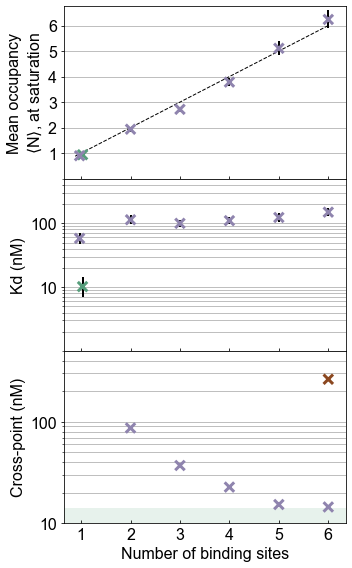

In [23]:
params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])
crosspoints_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','crosspoints.csv'), index_col=0)

plot_config = dict(
    tgts = {'a': ['A11XXXXX','M1XXXXX', 'M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX', 'M1M2M3M4M5X', 'M1M2M3M4M5M6'], 'k': ['A11XXXXX','M1XXXXX', 'M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX', 'M1M2M3M4M5X', 'M1M2M3M4M5M6'], 'crosspoint': ['M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX', 'M1M2M3M4M5X', 'M1M2M3M4M5M6','W2W3W1W4W3W2']
},
    figsize = (5,8),
    ptiles = [5, 95],
    ylims = {'a': [0, 6.75], 'k': [1e0, 5e2], 'crosspoint': [10,500]},
    slope = 0.6757,
    normalize = True,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)', 'crosspoint': 'Cross-point (nM)'},
    xlabel = 'Number of binding sites',
    markerColor = {'a': ['#579E7C','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE'], 'k':['#579E7C','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE'], 'crosspoint':['#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8B4820'] },
    yscales = {'a': 'linear', 'k': 'log', 'crosspoint':'log'},
    ymajorticks = {'a': [1, 2, 3, 4, 5, 6,], 'k': [10, 100, 1000], 'crosspoint':[10,100]},
    yminorticks = {'a': [1, 2, 3, 4, 5, 6, 7], 'k': None, 'crosspoint': None},
    ytickformat = {'a': '%d', 'k': '%d', 'crosspoint': '%d'},
    xticks=[1,2,3,4,5,6],
    xlim = [0.65,6.35],
#     invivoTFconc = 38,
    TfConcColor='#FFF200',
    fit_first_three = False,
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    crosspoints_df = crosspoints_df_data,
    saving = os.path.join(summary_plot_dir,'figure2E'))
make_target_summary_plot_fig2summary_crosspoints(plot_config, xinput=[1.03,0.97,2,3,4,5,6], modelClass='SBC', withModels=False, out='Fig2_KdBmax_MeanOcc_Crosspoints_log') 

### Figure 2 summary plots PHO4

#### log y-axis

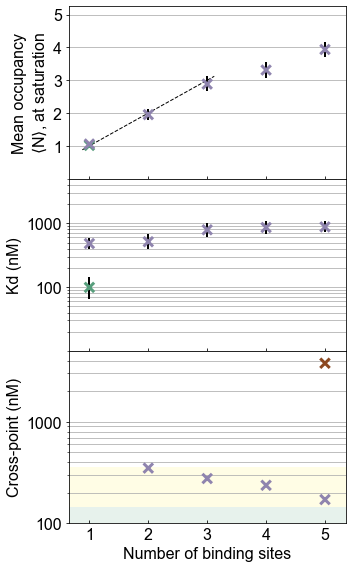

In [24]:
params_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])
crosspoints_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','crosspoints.csv'), index_col=0)

#supply strong tgt first
plot_config = dict(
    tgts = {'a':['S2XXXX','M1XXXX', 'M1M2XXX', 'M1M2M3XX', 'M1M2M3M4X', 'M1M2M3M4M5'], 'k':['S2XXXX','M1XXXX', 'M1M2XXX', 'M1M2M3XX', 'M1M2M3M4X', 'M1M2M3M4M5'], 'crosspoint':['M1M2XXX', 'M1M2M3XX', 'M1M2M3M4X', 'M1M2M3M4M5','W1W2W3W4W5']},
    figsize = (5,8),
    ptiles = [5,95],
    ylims = {'a': [0, 5.25], 'k': [1e1, 5e3], 'crosspoint': [100,5000]},
    slope = 1,
    normalize = True,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)', 'crosspoint': 'Cross-point (nM)'},
    xlabel = 'Number of binding sites',
    markerColor = {'a':['#579E7C','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE'], 'k':['#579E7C','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE'], 'crosspoint':['#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8B4820']},
    yscales = {'a': 'linear', 'k': 'log', 'crosspoint':'log'},
    ymajorticks = {'a': [1, 2, 3, 4, 5, ], 'k': [100, 1000], 'crosspoint':[100,1000]},
    yminorticks = {'a': [1, 2, 3, 4, 5, ], 'k': None, 'crosspoint': None},
    ytickformat = {'a': '%d', 'k': '%d', 'crosspoint': '%d'},
    xticks=[1,2,3,4,5],
    fit_first_three = True,
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    TfConcColor='#FFF200',
    invivoTFconc = 355,
    crosspoints_df = crosspoints_df_data,
    xlim = [0.65,5.35],
    saving = os.path.join(summary_plot_dir,'figure2J'))
make_target_summary_plot_fig2summary_crosspoints(plot_config, xinput=[1,1,2,3,4,5], modelClass='SBC', withModels=False, out=True)

## Figure 3 Plots

### Two-site position scan ZIF268

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 21. 31. 41.]


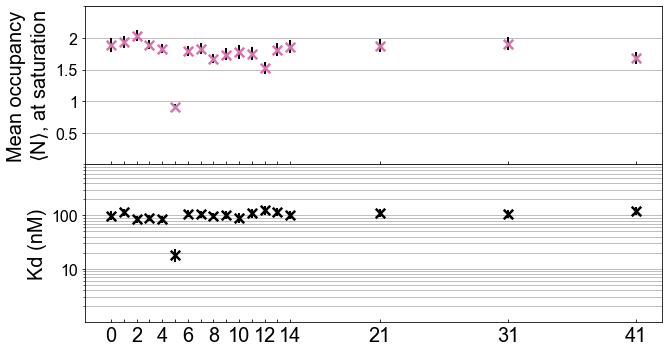

In [26]:
tgts = ['M1(0)M2XXXX','M1M2XXXX','M1(2)M2XXX','M1(3)M2XXX','M1(4)M2XXX','M1(5)M2XXX','M1(6)M2XXX','M1(7)M2XXX','M1(8)M2XXX','M1(9)M2XXX','M1(10)M2XXX','M1XM2XXX','M1(12)M2XXX','M1(13)M2XXX','M1(14)M2XXX','M1XXM2XX','M1XXXM2X','M1XXXXM2']
xdata = target_info.loc[tgts,'PosScanDistance'].values 
print(xdata)
xdata=np.array([int(tgt) for tgt in xdata])

params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    figsize = (4+0.3*18,5),
    ptiles = [5, 95],
    ylims = {'a': [0, 2.5], 'k': [1e0, 9e2]},
    slope = 0.6757,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)'},
    markerColor = {'a': '#D874AE', 'k': 'k'},  # could think about making a color gradient
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5,1.0,1.5,2.0], 'k': [10, 100, 1000]},
    yminorticks = {'a': [0.5,1.0,1.5, 2.0, 2.5, 3.0], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'},
    xticks=xdata,
    xticklabels=[0,'',2,'',4,'',6,'',8,'',10,'',12,'',14,21,31,41],
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    saving = os.path.join(summary_plot_dir,'figure3A'))
make_target_summary_plot_fig3_2sitepos(plot_config, xdata=xdata, modelClass='SBC', out='two-site-position-scan')

### Two-site position scan PHO4

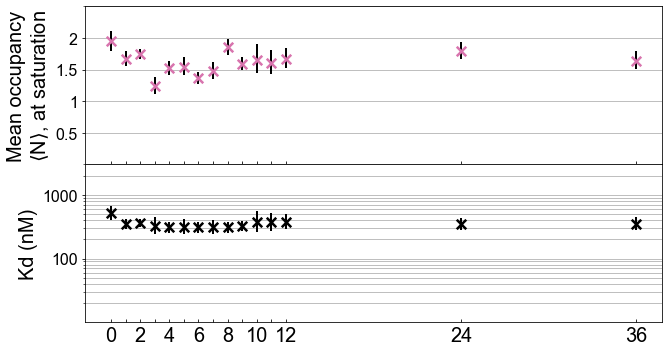

[ 0  1 10 11  2  3  4  5  6  7  8  9 12 24 36]


In [27]:
tgts = ['M1M2XXX','M1X(1)M2XX','M1X(10)M2XX','M1X(11)M2XX','M1X(2)M2XX','M1X(3)M2XX','M1X(4)M2XX','M1X(5)M2XX','M1X(6)M2XX','M1X(7)M2XX','M1X(8)M2XX','M1X(9)M2XX','M1XM2XX','M1XXM2X','M1XXXM2']

xdata = target_info.loc[tgts,'PosScanDistance'].values 
xdata=np.array([int(tgt) for tgt in xdata])

params_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    figsize = (4+0.3*18,5),
    ptiles = [5, 95],
    ylims = {'a': [0, 2.5], 'k': [1e1, 3e3]},
    slope = 1,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)'},
    markerColor = {'a': '#D874AE', 'k': 'k'},  # could think about making a color gradient
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5,1.0,1.5,2.0], 'k': [100, 1000]},
    yminorticks = {'a': [0.5,1.0,1.5, 2.0, 2.5, 3.0], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'},
    xticks=xdata, #start:stop:jump take every 2nd member of xdata after first element
    xticklabels=[0,'',10,'',2,'',4,'',6,'',8,'',12,24,36],
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    saving = os.path.join(summary_plot_dir,'figure3B'))
make_target_summary_plot_fig3_2sitepos(plot_config, xdata=xdata, modelClass='SBC', out='two-site-position-scan')
print(xdata)

### Number overlapping sites

#### All together

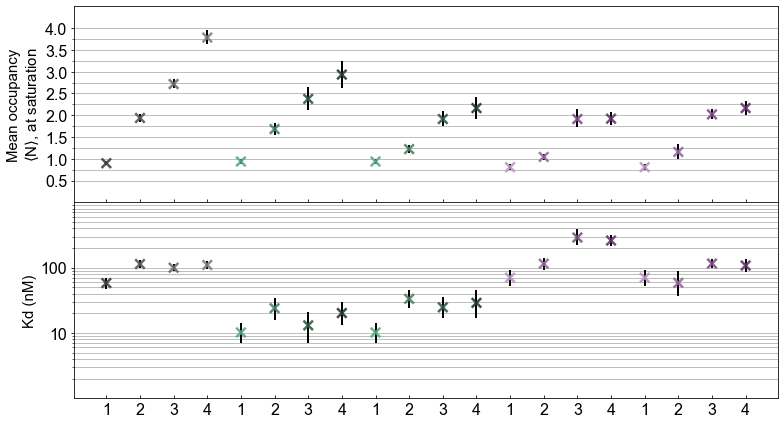

In [29]:
ptiles = [5, 95]

params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

tgts = ['M1XXXXX', 'M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX','A11XXXXX','(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)','A11XXXXX','(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)','M5XXXXX','(17)M5(-1)M5(56)','(17)M5(-1)M5(-1)M5(48)','(17)M5(-1)M5(-1)M5(-1)M5(40)','M5XXXXX','(17)M5(-3)M5(58)','(17)M5(-3)M5(-3)M5(52)','(17)M5(-3)M5(-3)M5(-3)M5(46)']

xdata = np.array(range(len(tgts)))

plot_config = dict(
    tgts = tgts,
    figsize = (5+0.3*len(tgts),6),
    ptiles = ptiles,
    ylims = {'a': [0, 4.5], 'k': [1e0, 1e3]},
    slope = 0.6757,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)'},
    markerColor = ['#414042','#58595B','#6D6E71','#808285', '#59AA84', '#4B8467', '#345C47', '#263D2F', '#59AA84', '#4B8467', '#345C47', '#263D2F', '#BD96C5', '#966A9E', '#844F8C', '#663670', '#BD96C5', '#966A9E', '#844F8C', '#663670'],
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5,1,1.5,2.0, 2.5,3.0,3.5,4.0], 'k': [10, 100]},
    yminorticks = {'a': [0.75,1.25,1.75,2.25,2.75,3.25,3.75], 'k': None},
    ytickformat = {'a': '%.1f', 'k': '%d'},
    xticks=xdata,
    xticklabels=[1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4],
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    saving = os.path.join(summary_plot_dir,'figure4F'))
make_target_summary_plot_fig3_ovlpsites(plot_config, xdata=xdata, modelClass='SBC', out='multi-site_ovlp-all_affinity_libraries_sbc')

### Number of mixed-affinity overlapping sites

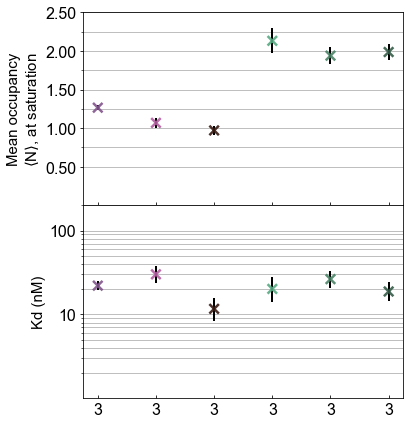

In [30]:
ptiles = [5, 95]

params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

tgts = ['(17)M5(-3)A11(-3)M5(52)','(17)A5(-3)A11(-3)A5(52)','(17)W4(-3)A11(-3)W4(52)','(17)A11(-3)M5(-3)A11(52)','(17)A11(-3)A5(-3)A11(52)','(17)A11(-3)W4(-3)A11(52)']

xdata = np.array(range(len(tgts)))

plot_config = dict(
    tgts = tgts,
    figsize = (4+0.3*len(tgts),6),
    ptiles = ptiles,
    ylims = {'a': [0, 2.5], 'k': [1e0, 2e2]},
    slope = 0.6757,
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'Kd (nM)'},

    markerColor = ['#82548C','#B35EA1','#3A1C14','#59AA84', '#4B8467', '#345C47'],

    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5,1.0,1.5,2.0,2.5,3.0], 'k': [10, 100]},
    yminorticks = {'a': [0.75,1.25,1.75,2.25,2.75], 'k': None},
    ytickformat = {'a': '%.2f', 'k': '%d'},
    xticks=xdata,
    xticklabels=[3,3,3,3,3,3],
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    saving = os.path.join(summary_plot_dir,'figure4H'))
make_target_summary_plot_fig3_ovlpsites(plot_config, xdata=xdata, modelClass='SBC', out='multi-site_ovlp-mixed-affinity_libraries_sbc')

## Supplementary plots

### Plotting affinity library - Pho4

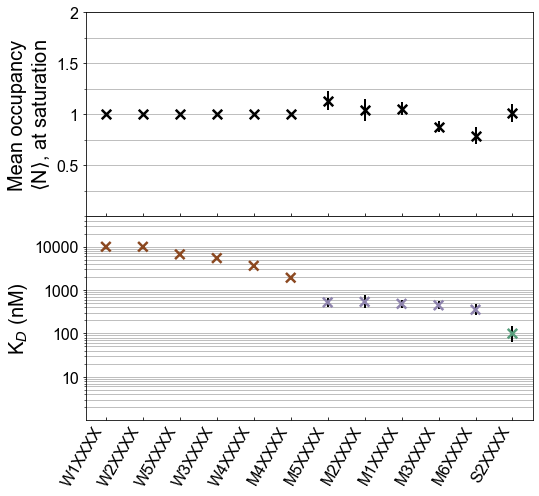

In [33]:
ptiles = [5, 95]

dir1 = 'misc_supplemental_plots'

plot_config = {}

tgts = ['W1XXXX','W2XXXX','W5XXXX','W3XXXX','W4XXXX','M4XXXX','M5XXXX', 'M2XXXX','M1XXXX', 'M3XXXX', 'M6XXXX','S2XXXX']

params_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    figsize = (4+0.3*len(tgts),7),
    ptiles = ptiles,
    ylims = {'a': [0, 2], 'k': [1e0, 5e4]},
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'K'+r'$_D$'+ ' (nM)'},
    markerColor = {'a': 'k', 'k': ['#8B4820','#8B4820','#8B4820','#8B4820','#8B4820','#8B4820','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#579E7C']},
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5, 1, 1.5, 2, 3, 4, 5, 6], 'k': [10, 100, 1000,10000]},
    yminorticks = {'a': [0.25,0.5,0.75,1,1.25,1.5,1.75], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'}, 
    params_df_data = params_df_data,
    ptiles_df_data = ptiles_df_data,
    title = '',
    saving = os.path.join(summary_plot_dir,'figureS3G')
)
make_target_summary_plot(plot_config, modelClass='SBC', withModels=False, out=os.path.join(dir1,'affinity_lib_Pho4_v2.jpg'))

### Plotting affinity library - Zif268

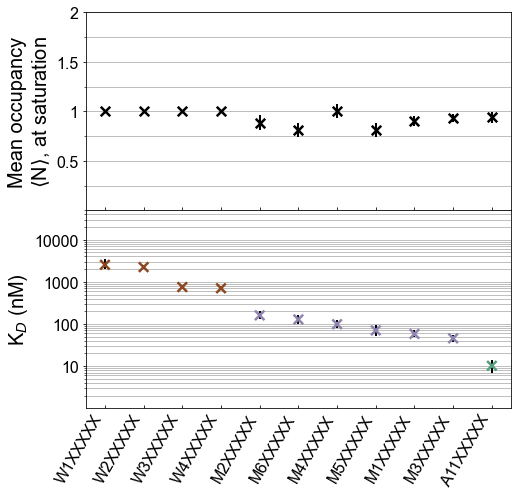

In [36]:
ptiles = [5, 95]

dir1 = 'misc_supplemental_plots'

plot_config = {}

tgts = ['W1XXXXX','W2XXXXX','W3XXXXX','W4XXXXX','M2XXXXX', 'M6XXXXX', 'M4XXXXX', 'M5XXXXX', 'M1XXXXX', 'M3XXXXX','A11XXXXX',]

params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    slope = 0.6757,
    figsize = (4+0.3*len(tgts),7),
    ptiles = ptiles,
    ylims = {'a': [0, 2], 'k': [1e0, 5e4]},
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'K'+r'$_D$'+ ' (nM)'},
    markerColor = {'a': 'k', 'k': ['#8B4820','#8B4820','#8B4820','#8B4820','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#8F84AE','#579E7C']},
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6], 'k': [10, 100, 1000,10000]},
    yminorticks = {'a': [0.25,0.5,0.75,1,1.25,1.5,1.75, 2, 2.25, 2.5, 2.75], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'},
    params_df_data = params_df_data,
    ptiles_df_data = ptiles_df_data,
    title='',
    saving = os.path.join(summary_plot_dir,'figureS3B')
)
make_target_summary_plot(plot_config, modelClass='SBC', withModels=False, out=os.path.join(dir1,'affinity_lib_Zif268.jpg'))


### Plotting DNA fluorescence equalization in plate

In [40]:
filename = 'DNA_plate2_post-equalize-conc.xlsx'
directory= 'input_datasets/in-vitro'
src = os.path.join(directory,filename)
datafile = pd.ExcelFile(src)

dfs = []
for sn in [sn for sn in datafile.sheet_names if not sn in ['README']]: 
    df = pd.read_excel(datafile, header=None, sheet_name=sn)
    dfs.append(df)

fdf = pd.concat(dfs)

plate_RFU_df = to_one_column(fdf, 'RFUs')
plate_RFU_df = plate_RFU_df.reset_index(drop=True)

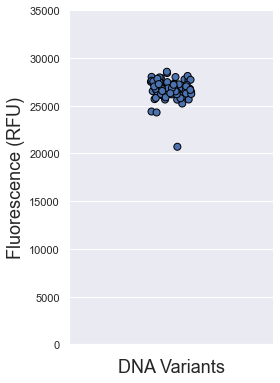

In [42]:
plot_config = dict(
    df = plate_RFU_df,
    figsize = (10,20),
    xlabel = 'DNA Variants',
    ylabel = 'Fluorescence (RFU)',
    y_colname = 'RFUs',
    hue_colname = 'RFUs',
    ymajorticks = [0,5000,10000,15000,20000,25000,30000],
    ytickformat = '%d',
    ylim = [0,35000],
    jitter=0,
    markerSize=7,
    height = 5,
    aspect = 0.75,
    saving = os.path.join(summary_plot_dir,'figureS1C')
)

plot_catplot_vert(plot_config)

## Note that plot will look different each time, seaborn adds jitter

### Plotting $\varepsilon_{clash}, \varepsilon_{bs}$, and Akaike information criteria (AIC)

0 de1
0 ehuh
0 aic
1 de1
1 ehuh
1 aic


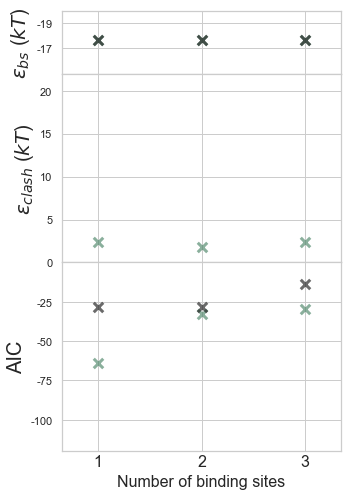

In [47]:
sns.set_style("whitegrid")

params_df_data1 = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Permissive_statmech','fit_params_smm_perm.csv'), index_col=0)
params_df_data2 = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Exclusive_statmech','fit_params_dependent-excl_rsq.csv'), index_col=0)

params_df_data2 = params_df_data2.rename(columns={"params1": "de1", "params2": "de2", "params3":'de3',"params4":'de4'})
params_df_data2["ehuh"] = np.nan

plot_config = dict(
    tgts = {0:{'de1': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)'], 'ehuh': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)'], 'aic': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)']},1:{'de1': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)'], 'ehuh': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)'], 'aic': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)']}},
    parameter_names = ['de1','ehuh','aic'],
    figsize = (5,7),
    xinput = [1,2,3],
    new_plot = True,
    ylims = {'de1': [-15, -20], 'ehuh': [0, 22], 'aic': [-120,0]},
    ylabels = {'de1': r'$\varepsilon_{bs}$'+' ('+r'$kT$'+')', 'ehuh': r'$\varepsilon_{clash}$'+' ('+r'$kT$'+')', 'aic': 'AIC'},
    xlabel = 'Number of binding sites',
    markerColor = {0:{'de1':'#4B8467' , 'ehuh':'#4B8467' , 'aic':'#4B8467'}, 1:{'de1':'k' , 'ehuh':'k' , 'aic':'k'} },
    yscales = {'de1': 'linear', 'ehuh': 'linear', 'aic':'linear'},
    ymajorticks = {'de1': [-17,-19], 'ehuh': [5,10,15,20], 'aic':[-100,-75,-50,-25,0]},
    yminorticks = {'de1': [1, 2, 3, 4, 5, 6, 7], 'ehuh': None, 'aic': None},
    ytickformat = {'de1': '%g', 'ehuh': '%g', 'aic': '%g'},
    xticks=[1,2,3],
    xlim = [0.65,3.35],
    params_dfs = [params_df_data1,params_df_data2],
    saving = os.path.join(summary_plot_dir,'figureS5A')
)
plot_misc_parameters(plot_config) 

0 de1
0 ehuh
0 aic
1 de1
1 ehuh
1 aic


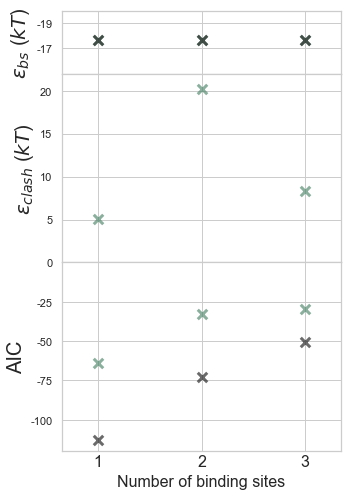

In [48]:
params_df_data1 = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Permissive_statmech','fit_params_smm_perm.csv'), index_col=0)
params_df_data2 = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Exclusive_statmech','fit_params_dependent-excl_rsq.csv'), index_col=0)

params_df_data2 = params_df_data2.rename(columns={"params1": "de1", "params2": "de2", "params3":'de3',"params4":'de4'})
params_df_data2["ehuh"] = np.nan
#'de1': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'ehuh': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'aic': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)']

plot_config = dict(
    tgts = {0:{'de1': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'ehuh': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'aic': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'aic': ['(17)A11(-1)A11(56)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(-1)A11(-1)A11(40)']},1:{'de1': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'ehuh': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)'], 'aic': ['(17)A11(-3)A11(58)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(-3)A11(-3)A11(46)']}},
    parameter_names = ['de1','ehuh','aic'],
    figsize = (5,7),
    xinput = [1,2,3],
    new_plot = True,
    ylims = {'de1': [-15, -20], 'ehuh': [0, 22], 'aic': [-120,0]},
    ylabels = {'de1': r'$\varepsilon_{bs}$'+' ('+r'$kT$'+')', 'ehuh': r'$\varepsilon_{clash}$'+' ('+r'$kT$'+')', 'aic': 'AIC'},
    xlabel = 'Number of binding sites',
    markerColor = {0:{'de1':'#4B8467' , 'ehuh':'#4B8467' , 'aic':'#4B8467'}, 1:{'de1':'k' , 'ehuh':'k' , 'aic':'k'} },
    yscales = {'de1': 'linear', 'ehuh': 'linear', 'aic':'linear'},
    ymajorticks = {'de1': [-17,-19], 'ehuh': [5,10,15,20], 'aic':[-100,-75,-50,-25,0]},
    yminorticks = {'de1': [1, 2, 3, 4, 5, 6, 7], 'ehuh': None, 'aic': None},
    ytickformat = {'de1': '%g', 'ehuh': '%g', 'aic': '%g'},
    xticks=[1,2,3],
    xlim = [0.65,3.35],
    params_dfs = [params_df_data1,params_df_data2],
    saving = os.path.join(summary_plot_dir,'figureS5B')
)
plot_misc_parameters(plot_config) 

### Hill multi-site medium scan

[1. 2. 3. 4. 5. 6.]


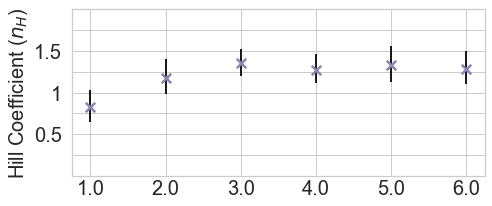

In [52]:
params_df_data = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Hill','fit_params_Hill.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Hill','fit_params_percentiles_Hill.csv'), index_col=[0,1])

tgts = ['M1XXXXX','M1M2XXXX','M1M2M3XXX','M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6']
plot_config = dict(
    tgts = tgts,
    parameterNames = ['n'],
    figsize = (7,3),
    ptiles = [5, 95],
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    ylims = {'n': [0, 2.0]},
    ylabels = {'n': 'Hill Coefficient ($n_H$)'},
    xlabels = {'n': ''},
    markerColor = {'n':'#8F84AE'},
    yscales = {'n': 'linear'},
    ymajorticks = {'n': [0.5, 1, 1.5]},
    yminorticks = {'n': [0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0]},
    ytickformat = {'n':'%.1f'},
    xtickformat = {'n':'%d'},
    title = '',
    saving = os.path.join(summary_plot_dir,'figureS4F')
)

make_target_summary_plot_numSites(plot_config, modelClass='Hill', withModels=False, plotError=True, out='misc_supplemental_plots/Multi-site-mediums_cooperativity_with-error')

### Hill Two site position scan

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 21. 31. 41.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 21 31 41]


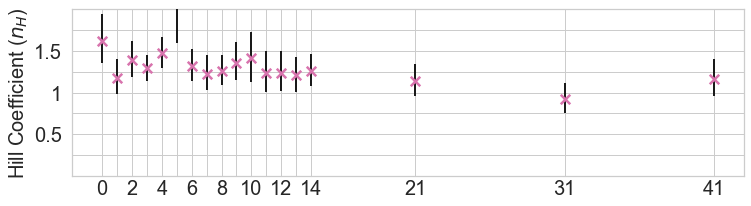

In [54]:
tgts = ['M1(0)M2XXXX','M1M2XXXX','M1(2)M2XXX','M1(3)M2XXX','M1(4)M2XXX','M1(5)M2XXX','M1(6)M2XXX','M1(7)M2XXX','M1(8)M2XXX','M1(9)M2XXX','M1(10)M2XXX','M1XM2XXX','M1(12)M2XXX','M1(13)M2XXX','M1(14)M2XXX','M1XXM2XX','M1XXXM2X','M1XXXXM2']
xdata = target_info.loc[tgts,'PosScanDistance'].values 
print(xdata)
xdata=np.array([int(tgt) for tgt in xdata])

params_df_data = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Hill','fit_params_Hill.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join('in-vitro_fits_plots','Zif268','Hill','fit_params_percentiles_Hill.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    parameterNames = ['n'],
    figsize = (4+0.3*22,3),
    ptiles = [5, 95],
    x_input = xdata,
    params_df = params_df_data,
    ptiles_df = ptiles_df_data,
    ylims = {'n': [0, 2.0]},
    ylabels = {'n': 'Hill Coefficient ($n_H$)'},
    xlabels = {'n': ''},
    markerColor = {'n':'#D874AE'},
    yscales = {'n': 'linear'},
    ymajorticks = {'n': [0.5, 1, 1.5]},
    yminorticks = {'n': [0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0]},
    xticks=xdata,
    xticklabels=[0,'',2,'',4,'',6,'',8,'',10,'',12,'',14,21,31,41],
    ytickformat = {'n':'%.1f'},
    title = '',
    saving = os.path.join(summary_plot_dir,'figureS4G')
)
make_target_summary_plot_numSites(plot_config, modelClass='Hill', withModels=False, plotError=True, out='misc_supplemental_plots/gap-scan_cooperativity_with-error')

### Single site position scan - Pho4

[62. 50. 38. 26. 14.]


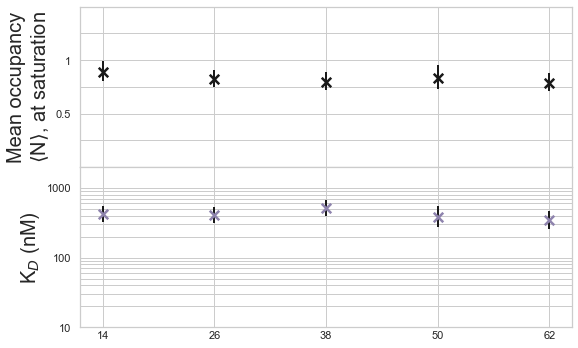

In [56]:
dir1 = 'misc_supplemental_plots'

tgts = ['M6XXXX','XM6XXX','XXM6XX','XXXM6X','XXXXM6']
xinput = target_info.loc[tgts,'PosScanDistance'].values 
print(xinput)
xinput=np.array([int(tgt) for tgt in xinput])
ptiles = [5, 95]

params_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Pho4path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    figsize = (8.2,5),
    ptiles = ptiles,
    ylims = {'a': [0, 1.5], 'k': [1e1, 2e3]},
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'K'+r'$_D$'+ ' (nM)'},
    markerColor = {'a': 'k', 'k': '#8F84AE'},
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [0.5, 1, 2, 3], 'k': [10, 100, 1000]},
    yminorticks = {'a': [0.25,0.5,0.75,1,1.25, 1.5, 2, 2.5, 3], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'},
    params_df_data = params_df_data,
    ptiles_df_data = ptiles_df_data,
    title = '',
    saving = os.path.join(summary_plot_dir,'figureS3J')
)
make_target_summary_plot(plot_config, xinput=xinput, modelClass='SBC', withModels=False, out=os.path.join(dir1,'single-site-position-scan_Pho4.jpg'))

### Single site position scan - Zif268

[64. 54. 44. 34. 32. 30. 28. 26. 24. 22. 20. 18. 16. 14.]


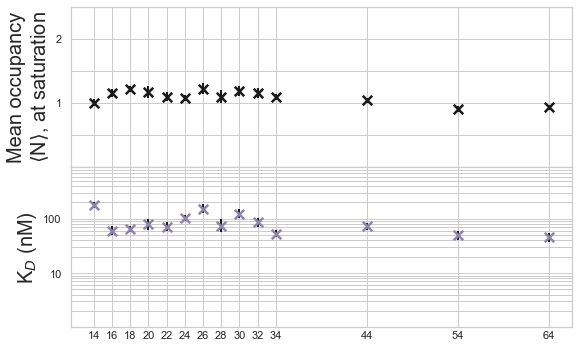

In [57]:
dir1 = 'misc_supplemental_plots'

tgts = ['M3XXXXX','XM3XXXX','XXM3XXX','XXXM3XX','(49)M3(32)','(51)M3(30)','(53)M3(28)','(55)M3(26)','XXXXM3X','(59)M3(22)','(61)M3(20)','(63)M3(18)','(65)M3(16)','XXXXXM3']
xinput = target_info.loc[tgts,'PosScanDistance'].values 
print(xinput)
xinput=np.array([int(tgt) for tgt in xinput])
ptiles = [5, 95]

params_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_sbc.csv'), index_col=0)
ptiles_df_data = pd.read_csv(os.path.join(Zif268path,'SBC','fit_params_percentiles_sbc.csv'), index_col=[0,1])

plot_config = dict(
    tgts = tgts,
    figsize = (4+0.3*len(tgts),5),
    ptiles = ptiles,
    slope = 0.6757,
    ylims = {'a': [0, 2.5], 'k': [1e0, 9e2]},
    ylabels = {'a': "Mean occupancy\n"+r"$\langle$"+ "N"+ r"$\rangle$"+ ", at saturation", 'k': 'K'+r'$_D$'+ ' (nM)'},
    markerColor = {'a': 'k', 'k': '#8F84AE'},
    yscales = {'a': 'linear', 'k': 'log'},
    ymajorticks = {'a': [1, 2, 3], 'k': [10, 100, 1000]},
    yminorticks = {'a': [0.5,1,1.5, 2, 2.5, 3], 'k': None},
    ytickformat = {'a': '%g', 'k': '%d'},
    params_df_data = params_df_data,
    ptiles_df_data = ptiles_df_data,
    title = '',
    saving = os.path.join(summary_plot_dir,'figureS3E')
)
make_target_summary_plot(plot_config, xinput=xinput, modelClass='SBC', withModels=False, out=os.path.join(dir1,'single-site-position-scan_Zif268.jpg'))